# Twitter Bot Accounts

[Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?select=twitter_human_bots_dataset.csv)


`friends_count` = Following

`followers_count` = Followers

In [92]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Data import and setup

### DF setup

In [2]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

In [3]:
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
raw_df.head(3)

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human


### Converting booleans to 1/0

In [5]:
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].apply(lambda x: 1 if x == True else 0)
raw_df['default_profile_image'] = raw_df['default_profile_image'].apply(lambda x: 1 if x == True else 0)
raw_df['geo_enabled'] = raw_df['geo_enabled'].apply(lambda x: 1 if x == True else 0)
raw_df['verified'] = raw_df['verified'].apply(lambda x: 1 if x == True else 0)


In [6]:
df = raw_df[['bot', 'screen_name', 'created_at', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days', 'description']]

In [7]:
del raw_df

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])

### Log transformations for highly skewed data

In [9]:
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

In [10]:
df.head(3)

,bot,screen_name,created_at,verified,location,geo_enabled,lang,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days,description,friends_log,followers_log,favs_log,avg_daily_tweets_log
0,1,best_in_dumbest,2016-10-15 21:32:11,0,unknown,0,en,0,0,4,1589,4,11041,7.870,1403,"Blame @xaiax, Inspired by @MakingInvisible, us...",1.609,7.371,1.609,2.183
1,0,CJRubinPhoto,2016-11-09 05:01:30,0,Estados Unidos,0,en,0,0,536,860,880,252,0.183,1379,Photographing the American West since 1980. I ...,6.781,6.758,6.286,0.168
2,0,SVGEGENT,2017-06-17 05:34:27,0,"Los Angeles, CA",1,en,0,0,3307,172,594,1001,0.864,1159,Scruffy looking nerf herder and @twitch broadc...,6.389,5.153,8.104,0.623


### Possible transformations to look at
* follower acquisition rate (`followers_count / account_age_days`)
* friends acquisition rate (`friends_count / account_age_days`)
* popularity (`friends_log` * `followers_log`)

In [11]:
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [12]:
df.head(3)

,bot,screen_name,created_at,verified,location,geo_enabled,lang,default_profile,default_profile_image,favourites_count,...,account_age_days,description,friends_log,followers_log,favs_log,avg_daily_tweets_log,popularity,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,0,unknown,0,en,0,0,4,...,1403,"Blame @xaiax, Inspired by @MakingInvisible, us...",1.609,7.371,1.609,2.183,11.860,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,0,Estados Unidos,0,en,0,0,536,...,1379,Photographing the American West since 1980. I ...,6.781,6.758,6.286,0.168,45.826,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,0,"Los Angeles, CA",1,en,0,0,3307,...,1159,Scruffy looking nerf herder and @twitch broadc...,6.389,5.153,8.104,0.623,32.923,0.138,0.414,0.414


## EDA

### Distribution Plots

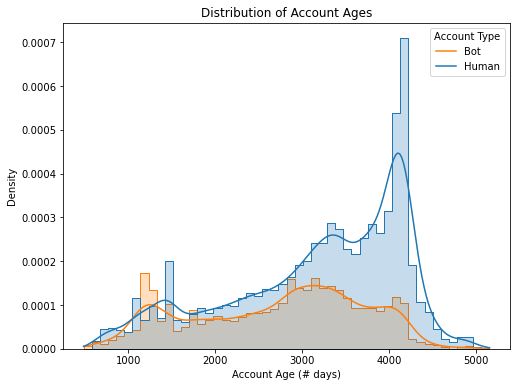

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(x='account_age_days', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Account Age (# days)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Account Ages');

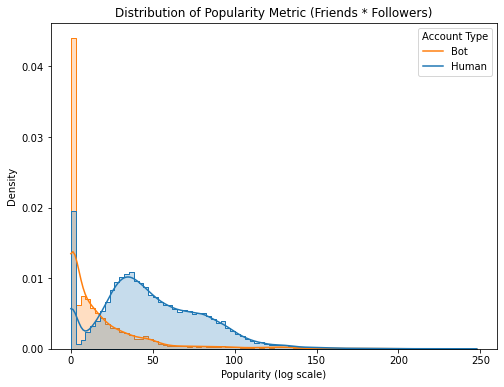

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(x='popularity', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Popularity (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Popularity Metric (Friends * Followers)');

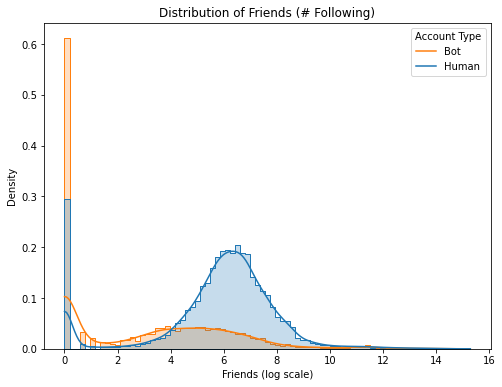

In [16]:
plt.figure(figsize=(8,6))
sns.histplot(x='friends_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Friends (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Friends (# Following)');

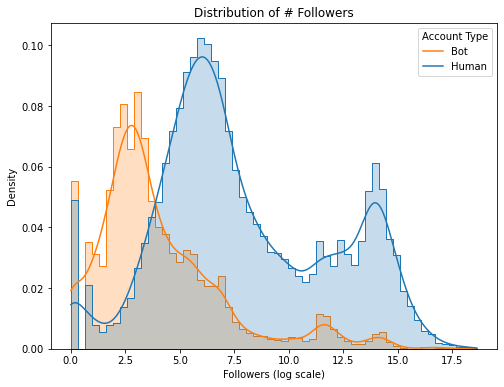

In [17]:
plt.figure(figsize=(8,6))
sns.histplot(x='followers_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Followers (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of # Followers');

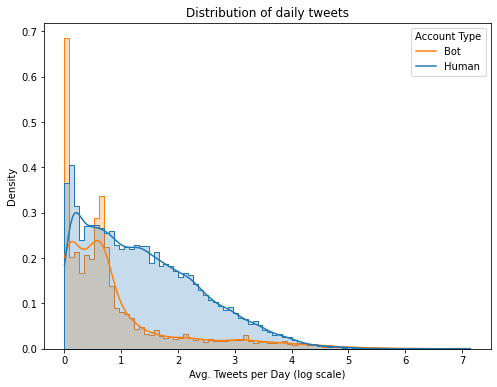

In [18]:
plt.figure(figsize=(8,6))
sns.histplot(x='avg_daily_tweets_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Avg. Tweets per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of daily tweets");

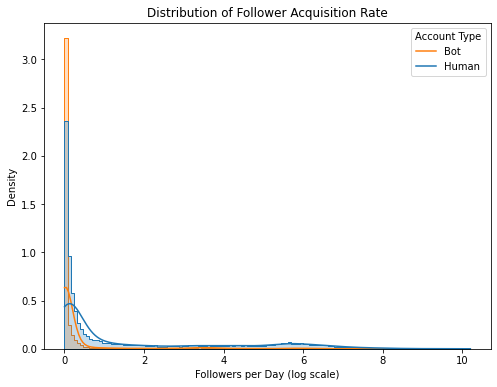

In [19]:
plt.figure(figsize=(8,6))
sns.histplot(x='follower_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Followers per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Follower Acquisition Rate");

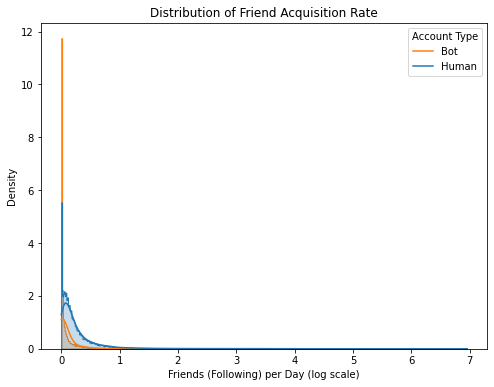

In [31]:
plt.figure(figsize=(8,6))
sns.histplot(x='friends_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Friends (Following) per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Friend Acquisition Rate");

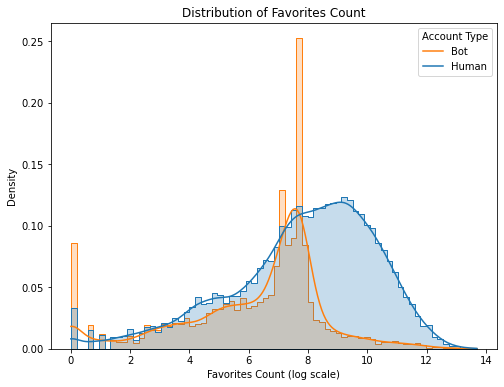

In [28]:
plt.figure(figsize=(8,6))
sns.histplot(x='favs_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Favorites Count (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Favorites Count");

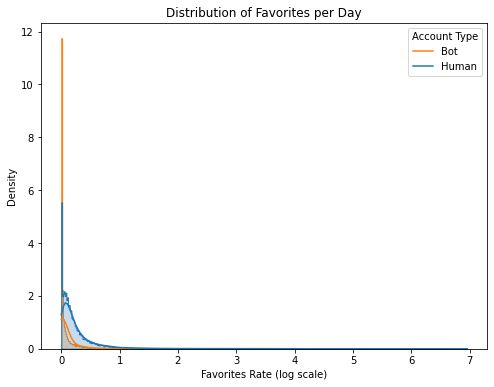

In [30]:
plt.figure(figsize=(8,6))
sns.histplot(x='favs_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Favorites Rate (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Favorites per Day");

### Correlations

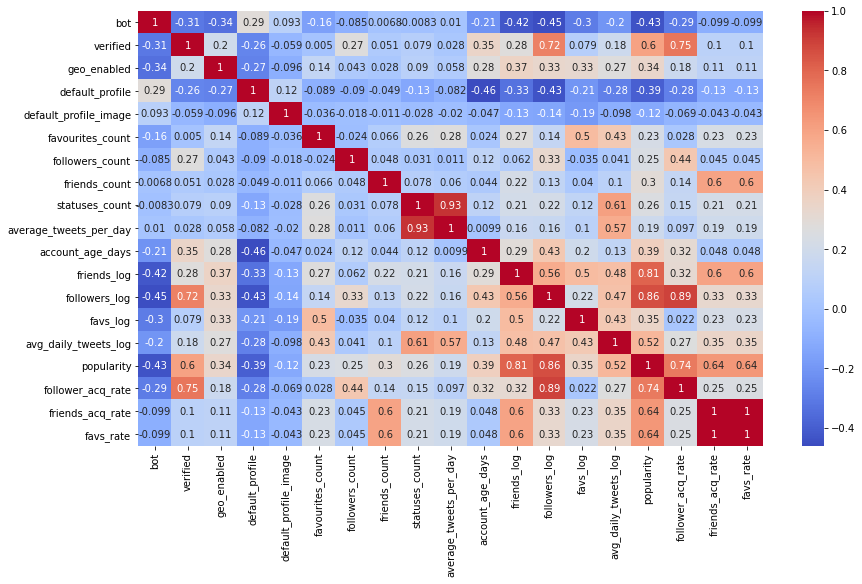

In [22]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap= 'coolwarm', annot=True);

In [23]:
bots = df[df['bot'] == 1]
humans = df[df['bot'] == 0]

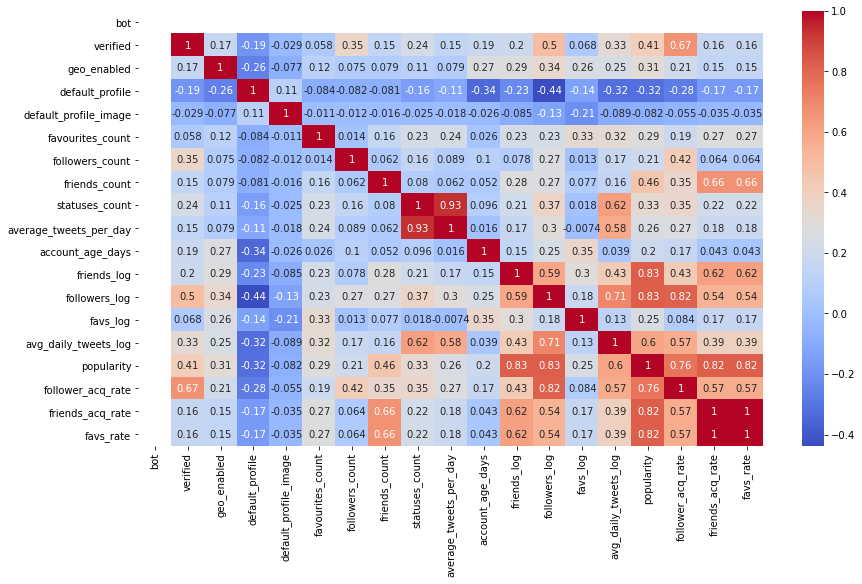

In [24]:
plt.figure(figsize=(14,8))
sns.heatmap(bots.corr(), cmap= 'coolwarm', annot=True);

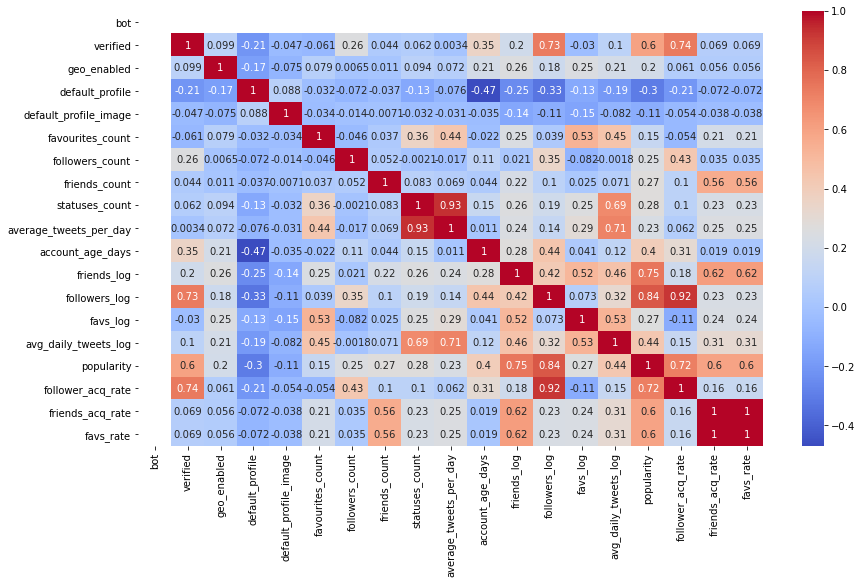

In [25]:
plt.figure(figsize=(14,8))
sns.heatmap(humans.corr(), cmap= 'coolwarm', annot=True);

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   bot                     37438 non-null  int64         
 1   screen_name             37438 non-null  object        
 2   created_at              37438 non-null  datetime64[ns]
 3   verified                37438 non-null  int64         
 4   location                37435 non-null  object        
 5   geo_enabled             37438 non-null  int64         
 6   lang                    29481 non-null  object        
 7   default_profile         37438 non-null  int64         
 8   default_profile_image   37438 non-null  int64         
 9   favourites_count        37438 non-null  int64         
 10  followers_count         37438 non-null  int64         
 11  friends_count           37438 non-null  int64         
 12  statuses_count          37438 non-null  int64 

## Modeling attempt? 

In [82]:
features = ['verified', 'favourites_count', 'followers_count', 'friends_count', 
           'statuses_count', 'average_tweets_per_day', 'popularity']

X = df[features]
y = df['bot']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

In [84]:
scalar = StandardScaler()

scalar.fit(X_train)

X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [85]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train, y_train, test_size=.3, random_state=2)

### KNN

In [86]:
ks = range(1, 30)

test_errors = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    
    nn = KNeighborsClassifier(n_neighbors = k)

    nn.fit(X_train_scaled, y_train)
    test_preds = nn.predict(X_val_scaled)
    
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_preds))
    #print(k, test_errors[i])

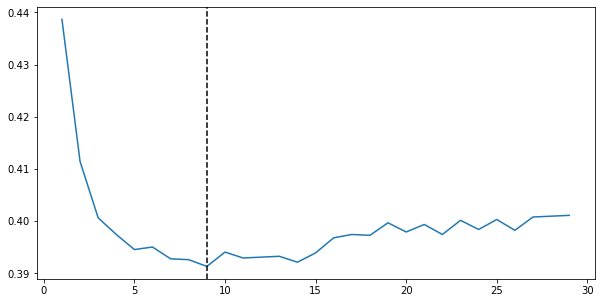

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), test_errors)
ax.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='black');

In [88]:
optimal_k = list(ks)[np.argmin(test_errors)]

optimal_error = np.min(test_errors)

print(f'Optimal number of Neighbors: {optimal_k}\nRoot Mean Squared Error: {optimal_error:.2f}')

Optimal number of Neighbors: 9
Root Mean Squared Error: 0.39


### Logistic Regression

In [89]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_val_scaled)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.94      0.79      5287
           1       0.49      0.13      0.20      2575

    accuracy                           0.67      7862
   macro avg       0.59      0.53      0.50      7862
weighted avg       0.62      0.67      0.60      7862



In [93]:
cm = confusion_matrix(y_val, y_pred)

In [94]:
cm

array([[4945,  342],
       [2252,  323]])

[Kaggle: Plot a confusion matrix](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)

In [97]:
def plot_cm(cm,
            target_names,
            title='Confusion matrix',
            cmap=None,
            normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

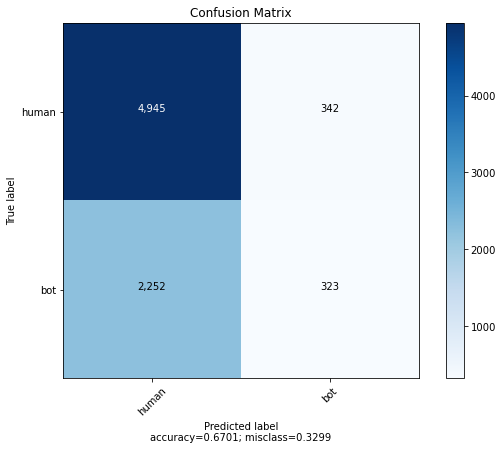

In [98]:
plot_cm(cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix')